In [ ]:
!pip uninstall -y tensorflow transformers torch tensorflow-estimator
!pip install torch
!pip install transformers
!pip install tensorflow

Found existing installation: transformers 4.47.0
Uninstalling transformers-4.47.0:
  Successfully uninstalled transformers-4.47.0
Found existing installation: torch 2.5.1
Uninstalling torch-2.5.1:
  Successfully uninstalled torch-2.5.1
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl (906.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.13.2 requires transformers, which is not installed.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, which is not installed.
  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.47.0-py3-none-any.whl (10.1 MB)
  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_

In [ ]:
!pip install datasets

In [ ]:
# IMPORT LIBRARY
from google.colab import drive
import re
import torch
from datasets import Dataset, DatasetDict
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# READ FILE
url = 'https://raw.githubusercontent.com/jejejery/IF5153-Tugas-Besar-Analisis-Promo/refs/heads/main/data/new_dataset_combine_promo_nonpromo_labeled.tsv'

data_promo_non_promo = pd.read_csv(url, sep='\t')
print(data_promo_non_promo.head())
print(len(data_promo_non_promo))

                                           full_text  label_promo  \
0  @mwanual Haloo yuk jajan layout di @parkyoriii...            1   
1  @raihanaulia_rar Ah iya Lotte dulu kesini buat...            1   
2  @tokopedia yang paling ku tungguinnn ° ° Disko...            1   
3  [Promo Pagiii] Promo Shopee Food hari ini disk...            1   
4  100% kulit sapi segar 100% bebas pemutih 100% ...            1   

   label_category  
0               6  
1               0  
2               6  
3               0  
4               6  
680


In [ ]:
# FILTERING DATA
# Data yang akan digunakan hanya yang berlabel promo (label_promo=1)
data_promo = data_promo_non_promo[data_promo_non_promo['label_promo'] == 1]
print(data_promo)
print(len(data_promo))

                                             full_text  label_promo  \
0    @mwanual Haloo yuk jajan layout di @parkyoriii...            1   
1    @raihanaulia_rar Ah iya Lotte dulu kesini buat...            1   
2    @tokopedia yang paling ku tungguinnn ° ° Disko...            1   
3    [Promo Pagiii] Promo Shopee Food hari ini disk...            1   
4    100% kulit sapi segar 100% bebas pemutih 100% ...            1   
..                                                 ...          ...   
503  Jangan lewatkan diskon 50% untuk pembelian sma...            1   
504  Dapatkan diskon 20% untuk pembelian produk tek...            1   
505  Promo spesial dari Google! Beli Google Nest Mi...            1   
506  Sewa drone untuk keperluan foto dan video deng...            1   
507  Promo baru dari Oppo! Dapatkan Oppo Reno 6 den...            1   

     label_category  
0                 6  
1                 0  
2                 6  
3                 0  
4                 6  
..             

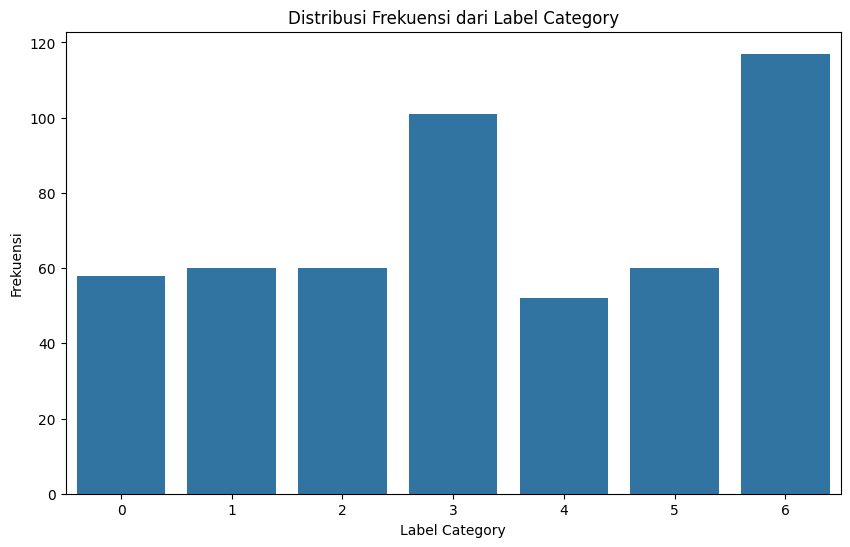

In [ ]:
# MELIHAT DISTRIBUSI FREKUENSI DARI LABEL CATEGORY
label_counts = data_promo['label_category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribusi Frekuensi dari Label Category')
plt.xlabel('Label Category')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
# IMBALANCE DATASET DI LABEL CATEGORY 3 DAN 6
# PENGHAPUSAN DATASET UNTUK LABEL CATEGORY 3 dan 6, SEMUA LABEL DATASET DIRATAKAN BERKISAR DI 60
print(data_promo["label_category"].value_counts())

# data_category_3 = data_promo[data_promo['label_category'] == 3].sample(n=60, random_state=42)
# data_category_6 = data_promo[data_promo['label_category'] == 6].sample(n=60, random_state=42)
# data_category_other = data_promo[~data_promo['label_category'].isin([3, 6])]
# data_balanced = pd.concat([data_category_other, data_category_3, data_category_6])
# data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# print(data_balanced['label_category'].value_counts())

# JADINYA MENGAMBIL SEMUA DATA KARENA AKURASINYA LEBIH BAIK
data_balanced = data_promo

label_category
6    117
3    101
2     60
5     60
1     60
0     58
4     52
Name: count, dtype: int64


**PRE PROCESSING DATA**

In [ ]:
# MASKING URL
def mask_url(text):
    url_list = re.findall(r'http\S+|www\S+|https\S+', text)
    masked_text = re.sub(r'http\S+|www\S+|https\S+', 'URL_TERMASKING', text)
    return masked_text, url_list

data_balanced['masked_text'] = data_balanced['full_text'].apply(lambda x: mask_url(x)[0])
print(data_balanced[['full_text', 'masked_text']])

                                             full_text  \
0    @mwanual Haloo yuk jajan layout di @parkyoriii...   
1    @raihanaulia_rar Ah iya Lotte dulu kesini buat...   
2    @tokopedia yang paling ku tungguinnn ° ° Disko...   
3    [Promo Pagiii] Promo Shopee Food hari ini disk...   
4    100% kulit sapi segar 100% bebas pemutih 100% ...   
..                                                 ...   
503  Jangan lewatkan diskon 50% untuk pembelian sma...   
504  Dapatkan diskon 20% untuk pembelian produk tek...   
505  Promo spesial dari Google! Beli Google Nest Mi...   
506  Sewa drone untuk keperluan foto dan video deng...   
507  Promo baru dari Oppo! Dapatkan Oppo Reno 6 den...   

                                           masked_text  
0    @mwanual Haloo yuk jajan layout di @parkyoriii...  
1    @raihanaulia_rar Ah iya Lotte dulu kesini buat...  
2    @tokopedia yang paling ku tungguinnn ° ° Disko...  
3    [Promo Pagiii] Promo Shopee Food hari ini disk...  
4    100% kulit sa

<ipython-input-9-07f244b2ced4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_balanced['masked_text'] = data_balanced['full_text'].apply(lambda x: mask_url(x)[0])


In [ ]:
# MASKING USERNAME
def mask_usernames(text):
    masked_text = re.sub(r'@\w+', 'USERNAME_MASKED', text)
    return masked_text

data_balanced['masked_usernames'] = data_balanced['masked_text'].apply(mask_usernames)
print(data_balanced[['full_text', 'masked_text', 'masked_usernames']])

                                             full_text  \
0    @mwanual Haloo yuk jajan layout di @parkyoriii...   
1    @raihanaulia_rar Ah iya Lotte dulu kesini buat...   
2    @tokopedia yang paling ku tungguinnn ° ° Disko...   
3    [Promo Pagiii] Promo Shopee Food hari ini disk...   
4    100% kulit sapi segar 100% bebas pemutih 100% ...   
..                                                 ...   
503  Jangan lewatkan diskon 50% untuk pembelian sma...   
504  Dapatkan diskon 20% untuk pembelian produk tek...   
505  Promo spesial dari Google! Beli Google Nest Mi...   
506  Sewa drone untuk keperluan foto dan video deng...   
507  Promo baru dari Oppo! Dapatkan Oppo Reno 6 den...   

                                           masked_text  \
0    @mwanual Haloo yuk jajan layout di @parkyoriii...   
1    @raihanaulia_rar Ah iya Lotte dulu kesini buat...   
2    @tokopedia yang paling ku tungguinnn ° ° Disko...   
3    [Promo Pagiii] Promo Shopee Food hari ini disk...   
4    100% kul

<ipython-input-10-092df86eb570>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_balanced['masked_usernames'] = data_balanced['masked_text'].apply(mask_usernames)


In [ ]:
# MASKING HASTAG
def mask_hashtags(text):
    masked_text = re.sub(r'#\w+', 'HASHTAG_MASKED', text)
    return masked_text

data_balanced['content_with_masked_hashtags'] = data_balanced['masked_usernames'].apply(mask_hashtags)
print(data_balanced[['masked_usernames', 'content_with_masked_hashtags']])

                                      masked_usernames  \
0    USERNAME_MASKED Haloo yuk jajan layout di USER...   
1    USERNAME_MASKED Ah iya Lotte dulu kesini buat ...   
2    USERNAME_MASKED yang paling ku tungguinnn ° ° ...   
3    [Promo Pagiii] Promo Shopee Food hari ini disk...   
4    100% kulit sapi segar 100% bebas pemutih 100% ...   
..                                                 ...   
503  Jangan lewatkan diskon 50% untuk pembelian sma...   
504  Dapatkan diskon 20% untuk pembelian produk tek...   
505  Promo spesial dari Google! Beli Google Nest Mi...   
506  Sewa drone untuk keperluan foto dan video deng...   
507  Promo baru dari Oppo! Dapatkan Oppo Reno 6 den...   

                          content_with_masked_hashtags  
0    USERNAME_MASKED Haloo yuk jajan layout di USER...  
1    USERNAME_MASKED Ah iya Lotte dulu kesini buat ...  
2    USERNAME_MASKED yang paling ku tungguinnn ° ° ...  
3    [Promo Pagiii] Promo Shopee Food hari ini disk...  
4    100% kulit sa

<ipython-input-11-328940dbe1ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_balanced['content_with_masked_hashtags'] = data_balanced['masked_usernames'].apply(mask_hashtags)


**FINE TUNNING PRE TRAINED MODEL INDOBERT P2**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

# TOKENIZER
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# MEMBAGI DATASET MENJADI TRAIN, VALID DAN TEST
X_train, X_test, y_train, y_test = train_test_split(data_balanced['content_with_masked_hashtags'],
                                                    data_balanced['label_category'],
                                                    test_size=0.2,
                                                    stratify=data_balanced['label_category'],
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      stratify=y_train,
                                                      random_state=42)
train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})
valid_dataset = Dataset.from_dict({
    'text': X_valid.tolist(),
    'label': y_valid.tolist()
})
test_dataset = Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_test.tolist()
})

In [ ]:
# FUNGSI TOKENISASI
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=512)

In [ ]:
# TOKENISASI UNTUK DATASET
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

In [ ]:
# CONVERT DATASET KE PYTORCH
def format_dataset(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

train_dataset = format_dataset(train_dataset)
valid_dataset = format_dataset(valid_dataset)
test_dataset = format_dataset(test_dataset)

In [ ]:
# GABUNGKAN DATASET MENJAD
dataset = DatasetDict({
    'train': train_dataset,
    'validation': valid_dataset,
    'test': test_dataset
})

# Verifikasi dataset akhir
print("\nFinal dataset:")
print(dataset)

# Cetak distribusi kelas untuk train, validation, dan test
print("\nDistribusi kelas:")
print("Train dataset:", pd.Series(dataset['train']['label']).value_counts())
print("Validation dataset:", pd.Series(dataset['validation']['label']).value_counts())
print("Test dataset:", pd.Series(dataset['test']['label']).value_counts())


Final dataset:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 324
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 82
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 102
    })
})

Distribusi kelas:
Train dataset: 6    74
3    65
1    38
2    38
5    38
0    37
4    34
Name: count, dtype: int64
Validation dataset: 6    19
3    16
5    10
1    10
2    10
0     9
4     8
Name: count, dtype: int64
Test dataset: 6    24
3    20
2    12
5    12
1    12
0    12
4    10
Name: count, dtype: int64


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=7)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# FUNGSI UNTUK MENGECEK AKURASI
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return classification_report(p.label_ids, preds, output_dict=True)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,0,1,2,3,4,5,6,Accuracy,Macro avg,Weighted avg
1,1.940900,1.897343,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.42857142857142855, 'recall': 0.3, 'f1-score': 0.35294117647058826, 'support': 10.0}","{'precision': 0.2222222222222222, 'recall': 0.6, 'f1-score': 0.32432432432432434, 'support': 10.0}","{'precision': 0.6666666666666666, 'recall': 0.75, 'f1-score': 0.7058823529411765, 'support': 16.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.13793103448275862, 'recall': 0.4, 'f1-score': 0.20512820512820512, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0}",0.304878,"{'precision': 0.20791305027758228, 'recall': 0.2928571428571428, 'f1-score': 0.2268965798377563, 'support': 82.0}","{'precision': 0.22626723804183854, 'recall': 0.3048780487804878, 'f1-score': 0.24534213056451223, 'support': 82.0}"
2,1.776200,1.690269,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 1.0, 'recall': 0.1, 'f1-score': 0.18181818181818182, 'support': 10.0}","{'precision': 0.4166666666666667, 'recall': 0.5, 'f1-score': 0.45454545454545453, 'support': 10.0}","{'precision': 0.6190476190476191, 'recall': 0.8125, 'f1-score': 0.7027027027027027, 'support': 16.0}","{'precision': 1.0, 'recall': 0.375, 'f1-score': 0.5454545454545454, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.4, 'recall': 0.9473684210526315, 'f1-score': 0.5625, 'support': 19.0}",0.487805,"{'precision': 0.4908163265306122, 'recall': 0.3906954887218045, 'f1-score': 0.34957441207441203, 'support': 82.0}","{'precision': 0.4837979094076655, 'recall': 0.4878048780487805, 'f1-score': 0.3982684874453168, 'support': 82.0}"
3,1.503900,1.389443,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.7777777777777778, 'recall': 0.7, 'f1-score': 0.7368421052631579, 'support': 10.0}","{'precision': 0.8, 'recall': 0.4, 'f1-score': 0.5333333333333333, 'support': 10.0}","{'precision': 0.9230769230769231, 'recall': 0.75, 'f1-score': 0.8275862068965517, 'support': 16.0}","{'precision': 0.6363636363636364, 'recall': 0.875, 'f1-score': 0.7368421052631579, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.4090909090909091, 'recall': 0.9473684210526315, 'f1-score': 0.5714285714285714, 'support': 19.0}",0.585366,"{'precision': 0.5066156066156066, 'recall': 0.5246240601503759, 'f1-score': 0.486576046026396, 'support': 82.0}","{'precision': 0.5293981086664014, 'recall': 0.5853658536585366, 'f1-score': 0.5206708950677787, 'support': 82.0}"
4,1.224700,1.068814,"{'precision': 1.0, 'recall': 0.4444444444444444, 'f1-score': 0.6153846153846154, 'support': 9.0}","{'precision': 0.875, 'recall': 0.7, 'f1-score': 0.7777777777777778, 'support': 10.0}","{'precision': 0.6666666666666666, 'recall': 0.4, 'f1-score': 0.5, 'support': 10.0}","{'precision': 0.875, 'recall': 0.875, 'f1-score': 0.875, 'support': 16.0}","{'precision': 0.5833333333333334, 'recall': 0.875, 'f1-score': 0.7, 'support': 8.0}","{'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 10.0}","{'precision': 0.5483870967741935, 'recall': 0.8947368421052632, 'f1-score': 0.68, 'support': 19.0}",0.707317,"{'precision': 0.7926267281105991, 'recall': 0.6698830409356724, 'f1-score': 0.6878327228327228, 'support': 82.0}","{'precision': 0.7744230264883294, 'recall': 0.7073170731707317, 'f1-score': 0.7012549510110486, 'support': 82.0}"
5,0.841800,0.785864,"{'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 9.0}","{'precision': 1.0, 'recall': 0.8, 'f1-score': 0.8888888888888888, 'support': 10.0}","{'precision': 0.625, 'recall': 0.5, 'f1-score': 0.5555555555555556, 'support': 10.0}","{'precision': 1.0, 'recall': 0.9375, 'f1-score': 0.967741935483871, 'support': 16.0}","{'precision': 0.6363636363636364, 'rec

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'precis

TrainOutput(global_step=105, training_loss=1.4965121768769765, metrics={'train_runtime': 110.592, 'train_samples_per_second': 14.648, 'train_steps_per_second': 0.949, 'total_flos': 86583868488000.0, 'train_loss': 1.4965121768769765, 'epoch': 5.0})

In [ ]:
results = trainer.evaluate(dataset['test'])
print("\nEvaluasi Hasil:")
print(results)
predictions = trainer.predict(dataset['test'])
preds = np.argmax(predictions.predictions, axis=1)
print("\nClassification Report pada Test Data:")
print(classification_report(predictions.label_ids, preds))

Trainer is attempting to log a value of "{'precision': 0.8888888888888888, 'recall': 0.6666666666666666, 'f1-score': 0.7619047619047619, 'support': 12.0}" of type <class 'dict'> for key "eval/0" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.9230769230769231, 'support': 12.0}" of type <class 'dict'> for key "eval/1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 12.0}" of type <class 'dict'> for key "eval/2" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9047619047619048, 'recall': 0.95, 'f1-score': 0.926829268292683, 'support': 20.0}" of ty


Evaluasi Hasil:
{'eval_loss': 0.8195965886116028, 'eval_0': {'precision': 0.8888888888888888, 'recall': 0.6666666666666666, 'f1-score': 0.7619047619047619, 'support': 12.0}, 'eval_1': {'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.9230769230769231, 'support': 12.0}, 'eval_2': {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 12.0}, 'eval_3': {'precision': 0.9047619047619048, 'recall': 0.95, 'f1-score': 0.926829268292683, 'support': 20.0}, 'eval_4': {'precision': 0.6666666666666666, 'recall': 0.6, 'f1-score': 0.631578947368421, 'support': 10.0}, 'eval_5': {'precision': 0.8571428571428571, 'recall': 0.5, 'f1-score': 0.631578947368421, 'support': 12.0}, 'eval_6': {'precision': 0.7, 'recall': 0.875, 'f1-score': 0.7777777777777778, 'support': 24.0}, 'eval_accuracy': 0.7941176470588235, 'eval_macro avg': {'precision': 0.8035147392290248, 'recall': 0.7630952380952382, 'f1-score': 0.7718209465412841, 'support': 102.0}, 'eval_weighted avg': {'precision': 0.801960

In [ ]:
output_dir = '/content/drive/MyDrive/TUGAS BESAR NLP/MODEL/Promo-Category Classification/IndoBERT'

os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir, legacy_format=False)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
